In [67]:

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import mysql.connector
from mysql.connector import Error

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

import yagmail
import os

### Data Collection and Preparation

In [12]:
# Function to load and prepare data
def load_and_prepare_data():
    sales_data = pd.read_csv('Data/SalesFinal.csv')
    purchase_data = pd.read_csv('Data/PurchasesFinal.csv')
    invoice_data = pd.read_csv('Data/InvoicePurchases.csv')
    ending_inventory = pd.read_csv('Data/EndInvFinal.csv')
    beginning_inventory = pd.read_csv('Data/BegInvFinal.csv')
    purchase_prices = pd.read_csv('Data/2017PurchasePricesDec.csv')
    
    dataframes = [sales_data, purchase_data, invoice_data, ending_inventory, beginning_inventory, purchase_prices]
    for df in dataframes:
        df.fillna(0, inplace=True)
        df.columns = [col.strip() for col in df.columns]
        
    sales_data['SalesDate'] = pd.to_datetime(sales_data['SalesDate'])
    purchase_data['PODate'] = pd.to_datetime(purchase_data['PODate'])
    invoice_data['InvoiceDate'] = pd.to_datetime(invoice_data['InvoiceDate'])
    ending_inventory['endDate'] = pd.to_datetime(ending_inventory['endDate'])
    beginning_inventory['startDate'] = pd.to_datetime(beginning_inventory['startDate'])
    
    return sales_data, purchase_data, invoice_data, ending_inventory, beginning_inventory, purchase_prices

sales_data, purchase_data, invoice_data, ending_inventory, beginning_inventory, purchase_prices = load_and_prepare_data()


In [13]:
def display_data_info():
    data_info = {
        "Sales Data": sales_data,
        "Purchase Data": purchase_data,
        "Invoice Data": invoice_data,
        "Ending Inventory": ending_inventory,
        "Beginning Inventory": beginning_inventory,
        "Purchase Prices": purchase_prices
    }
    for name, df in data_info.items():
        print(f"\n{name} Data")
        print(df.head())
        print(df.shape)
        print(df.dtypes)

display_data_info()


Sales Data Data
           InventoryId  Store  Brand                 Description        Size  \
0  1_HARDERSFIELD_1004      1   1004  Jim Beam w/2 Rocks Glasses       750mL   
1  1_HARDERSFIELD_1004      1   1004  Jim Beam w/2 Rocks Glasses       750mL   
2  1_HARDERSFIELD_1004      1   1004  Jim Beam w/2 Rocks Glasses       750mL   
3  1_HARDERSFIELD_1004      1   1004  Jim Beam w/2 Rocks Glasses       750mL   
4  1_HARDERSFIELD_1005      1   1005     Maker's Mark Combo Pack  375mL 2 Pk   

   SalesQuantity  SalesDollars  SalesPrice  SalesDate  Volume  Classification  \
0              1         16.49       16.49 2016-01-01     750               1   
1              2         32.98       16.49 2016-01-02     750               1   
2              1         16.49       16.49 2016-01-03     750               1   
3              1         14.49       14.49 2016-01-08     750               1   
4              2         69.98       34.99 2016-01-09     375               1   

   ExciseTax  V

C:\Users\navsa\AppData\Local\Temp\ipykernel_20200\2636140192.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x='SalesDate', y='SalesQuantity', data=sales_data, estimator='sum', ci=None)


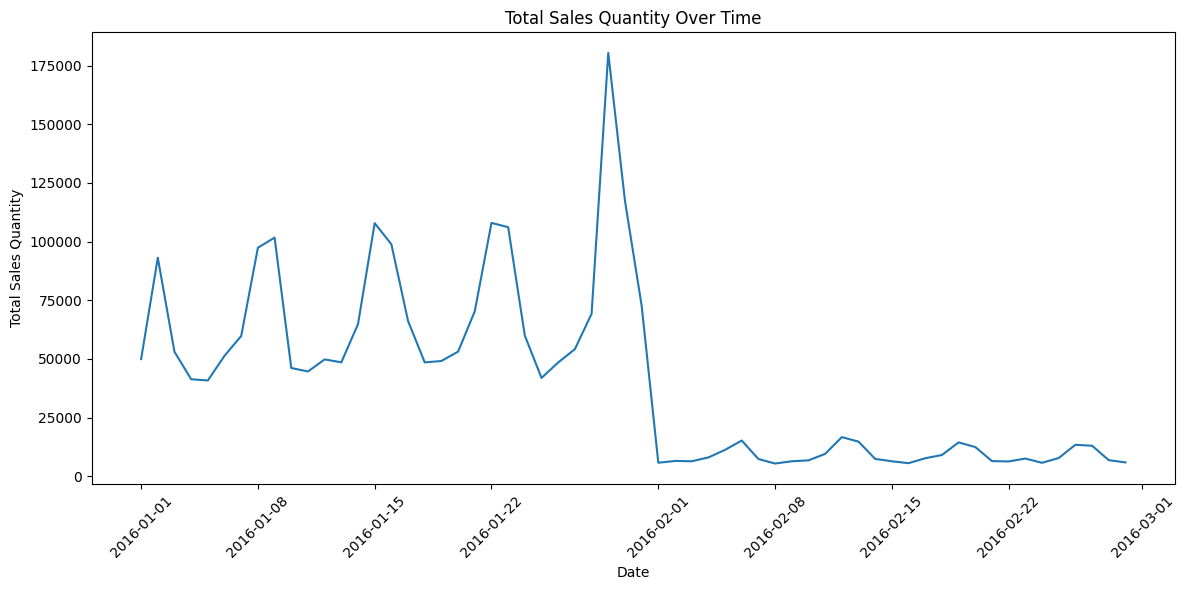

In [14]:
# Plotting sales quantity over time
plt.figure(figsize=(12, 6))
sns.lineplot(x='SalesDate', y='SalesQuantity', data=sales_data, estimator='sum', ci=None)
plt.title('Total Sales Quantity Over Time')
plt.xlabel('Date')
plt.ylabel('Total Sales Quantity')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Objective 1
Analyzing inventory data to optimize stock levels and determine reorder points for efficient inventory management. By leveraging sales, purchase, and inventory data, the goal is to identify overstocked and understocked items, calculate reorder points, and enhance supply chain efficiency.

In [15]:
# Merge beginning and ending inventory data
inventory_data = pd.merge(beginning_inventory, ending_inventory, on='InventoryId', suffixes=('_begin', '_end'))

In [16]:
# Calculate the change in inventory levels
inventory_data['stock_change'] = inventory_data['onHand_end'] - inventory_data['onHand_begin']


In [17]:
print("\nInventory Data")
print(inventory_data.head())


Inventory Data
         InventoryId  Store_begin    City_begin  Brand_begin  \
0  1_HARDERSFIELD_58            1  HARDERSFIELD           58   
1  1_HARDERSFIELD_62            1  HARDERSFIELD           62   
2  1_HARDERSFIELD_63            1  HARDERSFIELD           63   
3  1_HARDERSFIELD_72            1  HARDERSFIELD           72   
4  1_HARDERSFIELD_75            1  HARDERSFIELD           75   

             Description_begin Size_begin  onHand_begin  Price_begin  \
0  Gekkeikan Black & Gold Sake      750mL             8        12.99   
1     Herradura Silver Tequila      750mL             6        36.99   
2   Herradura Reposado Tequila      750mL             3        38.99   
3         No. 3 London Dry Gin      750mL             6        34.99   
4    Three Olives Tomato Vodka      750mL            18        14.99   

   startDate  Store_end      City_end  Brand_end              Description_end  \
0 2016-01-01          1  HARDERSFIELD         58  Gekkeikan Black & Gold Sake   
1 20

Get Under stocked and overstocked Data

In [18]:
# Identify overstocked and understocked items
overstocked_items = inventory_data[inventory_data['stock_change'] > 0]
understocked_items = inventory_data[inventory_data['stock_change'] < 0]


In [19]:
print("Over stocked")
print(overstocked_items["InventoryId"].head())
print(overstocked_items.shape)

print("Under Stocked")
print(understocked_items["InventoryId"].head())
print(understocked_items.shape)

Over stocked
0    1_HARDERSFIELD_58
1    1_HARDERSFIELD_62
2    1_HARDERSFIELD_63
5    1_HARDERSFIELD_77
6    1_HARDERSFIELD_79
Name: InventoryId, dtype: object
(82656, 18)
Under Stocked
3      1_HARDERSFIELD_72
4      1_HARDERSFIELD_75
11    1_HARDERSFIELD_178
15    1_HARDERSFIELD_254
16    1_HARDERSFIELD_261
Name: InventoryId, dtype: object
(80850, 18)


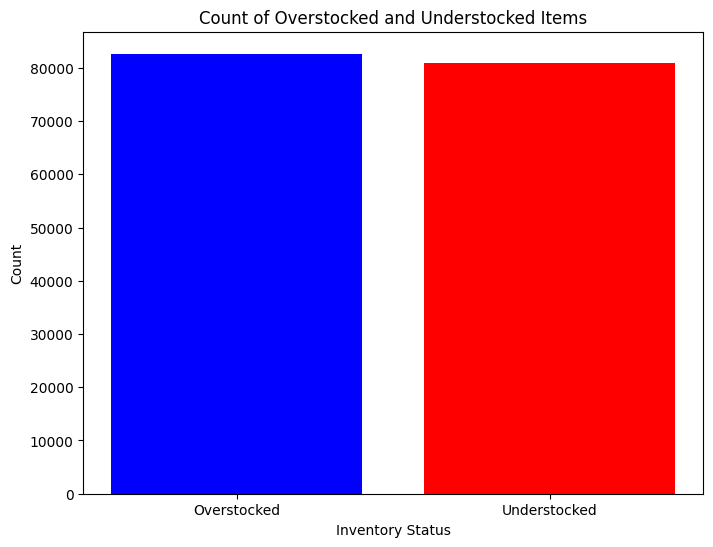

In [20]:
# Count the number of overstocked and understocked items
overstocked_count = overstocked_items.shape[0]
understocked_count = understocked_items.shape[0]

# Plotting the bar graph
plt.figure(figsize=(8, 6))
plt.bar(['Overstocked', 'Understocked'], [overstocked_count, understocked_count], color=['blue', 'red'])
plt.title('Count of Overstocked and Understocked Items')
plt.xlabel('Inventory Status')
plt.ylabel('Count')
plt.show()

Calculate reorder point

In [21]:
# Calculate the average sales quantity for each item
sales_data_grouped = sales_data.groupby('InventoryId')['SalesQuantity'].mean().reset_index()

print(sales_data_grouped.head())
print(sales_data_grouped.shape)

        InventoryId  SalesQuantity
0   10_HORNSEY_1000       1.000000
1   10_HORNSEY_1001       3.666667
2  10_HORNSEY_10030       2.000000
3   10_HORNSEY_1005       1.000000
4  10_HORNSEY_10057      12.000000
(170131, 2)


In [22]:
# Merge sales data with inventory data
inventory_data = pd.merge(inventory_data, sales_data_grouped, on='InventoryId')

print(inventory_data.head())
print(inventory_data.shape)

         InventoryId  Store_begin    City_begin  Brand_begin  \
0  1_HARDERSFIELD_58            1  HARDERSFIELD           58   
1  1_HARDERSFIELD_62            1  HARDERSFIELD           62   
2  1_HARDERSFIELD_63            1  HARDERSFIELD           63   
3  1_HARDERSFIELD_75            1  HARDERSFIELD           75   
4  1_HARDERSFIELD_77            1  HARDERSFIELD           77   

             Description_begin Size_begin  onHand_begin  Price_begin  \
0  Gekkeikan Black & Gold Sake      750mL             8        12.99   
1     Herradura Silver Tequila      750mL             6        36.99   
2   Herradura Reposado Tequila      750mL             3        38.99   
3    Three Olives Tomato Vodka      750mL            18        14.99   
4  Three Olives Espresso Vodka      750mL             7        14.99   

   startDate  Store_end      City_end  Brand_end              Description_end  \
0 2016-01-01          1  HARDERSFIELD         58  Gekkeikan Black & Gold Sake   
1 2016-01-01        

In [23]:
# Calculate the reorder point for each item
inventory_data['reorder_point'] = inventory_data['onHand_end'] - (inventory_data['SalesQuantity'] * 2)

print(inventory_data.head())
print(inventory_data.shape)

         InventoryId  Store_begin    City_begin  Brand_begin  \
0  1_HARDERSFIELD_58            1  HARDERSFIELD           58   
1  1_HARDERSFIELD_62            1  HARDERSFIELD           62   
2  1_HARDERSFIELD_63            1  HARDERSFIELD           63   
3  1_HARDERSFIELD_75            1  HARDERSFIELD           75   
4  1_HARDERSFIELD_77            1  HARDERSFIELD           77   

             Description_begin Size_begin  onHand_begin  Price_begin  \
0  Gekkeikan Black & Gold Sake      750mL             8        12.99   
1     Herradura Silver Tequila      750mL             6        36.99   
2   Herradura Reposado Tequila      750mL             3        38.99   
3    Three Olives Tomato Vodka      750mL            18        14.99   
4  Three Olives Espresso Vodka      750mL             7        14.99   

   startDate  Store_end      City_end  Brand_end              Description_end  \
0 2016-01-01          1  HARDERSFIELD         58  Gekkeikan Black & Gold Sake   
1 2016-01-01        

Get items to reorder (Currently)

In [24]:
# Identify items that need to be reordered
items_to_reorder = inventory_data[inventory_data['reorder_point'] < 0]

print("\nItems to reorder:")
print(f"{items_to_reorder["InventoryId"].head()} \n {items_to_reorder["Description_begin"].head()}")
print(items_to_reorder.shape)


Items to reorder:
24     1_HARDERSFIELD_381
44     1_HARDERSFIELD_539
81     1_HARDERSFIELD_950
87    1_HARDERSFIELD_1060
88    1_HARDERSFIELD_1065
Name: InventoryId, dtype: object 
 24    Baileys Irish Cream w/4 Glss
44                  Bowman's Vodka
81        Mastersons 10 Yr Old Rye
87    Jack Daniels Bruins Glass Pk
88    DiSaronno Cavalli Collection
Name: Description_begin, dtype: object
(7220, 20)


#### get thresholds for reorder of every product

In [25]:
# calculate average daily sales
average_daily_sales = sales_data.groupby('Description')['SalesQuantity'].mean().reset_index()

print("Average daily sales:")
print(average_daily_sales.head())
print(average_daily_sales.shape)

Average daily sales:
                  Description  SalesQuantity
0                      (RI) 1       1.081081
1         10 Span Cab Svgn CC      12.000000
2            10 Span Chard CC      14.000000
3           10 Span Pnt Nr CC       5.166667
4  12 Days of Pearls Gift Set       1.238095
(6890, 2)


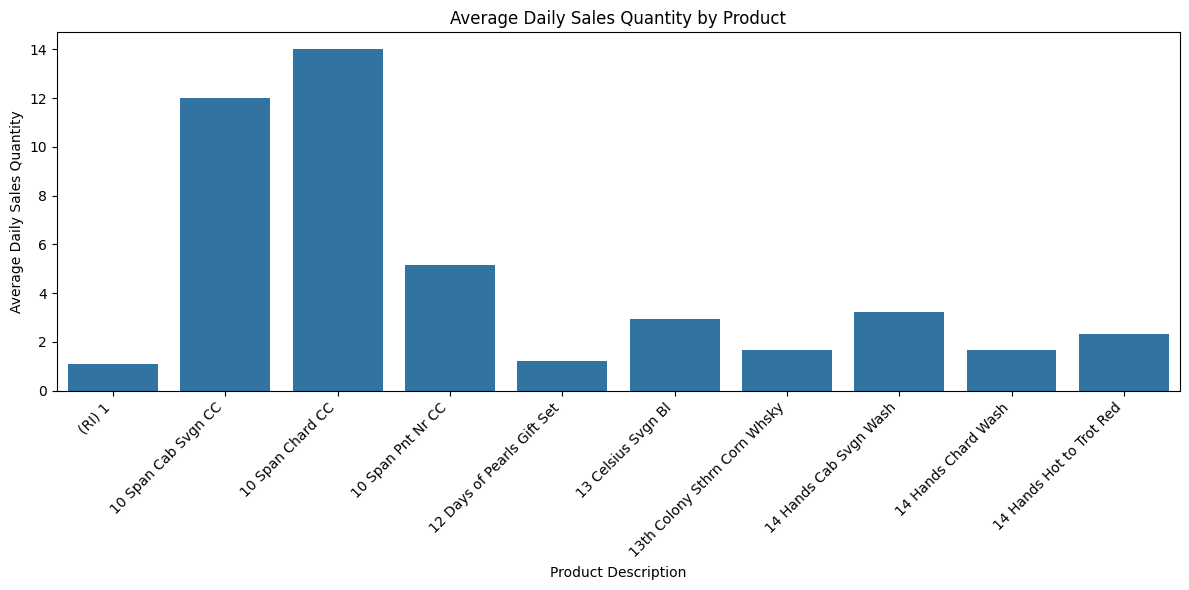

In [26]:
# Plotting bar graph for average daily sales
plt.figure(figsize=(12, 6))
sns.barplot(x='Description', y='SalesQuantity', data=average_daily_sales.head(10))
plt.xticks(rotation=45, ha='right')
plt.title('Average Daily Sales Quantity by Product')
plt.xlabel('Product Description')
plt.ylabel('Average Daily Sales Quantity')
plt.tight_layout()
plt.show()

In [27]:
# Merge the Begining_inventory and ending_inventory datasets on the InventoryId
merged_inventory = pd.merge(beginning_inventory, ending_inventory, on='InventoryId')

print(merged_inventory.columns)
print(merged_inventory.shape)

Index(['InventoryId', 'Store_x', 'City_x', 'Brand_x', 'Description_x',
       'Size_x', 'onHand_x', 'Price_x', 'startDate', 'Store_y', 'City_y',
       'Brand_y', 'Description_y', 'Size_y', 'onHand_y', 'Price_y', 'endDate'],
      dtype='object')
(174976, 17)


In [28]:
# Calculate the time difference between the Start Date and the End Date for each sale.
merged_inventory['LeadTime'] = (merged_inventory['endDate'] - merged_inventory['startDate']).dt.days

print(merged_inventory.columns)
print(merged_inventory.shape)

Index(['InventoryId', 'Store_x', 'City_x', 'Brand_x', 'Description_x',
       'Size_x', 'onHand_x', 'Price_x', 'startDate', 'Store_y', 'City_y',
       'Brand_y', 'Description_y', 'Size_y', 'onHand_y', 'Price_y', 'endDate',
       'LeadTime'],
      dtype='object')
(174976, 18)


Calculate Lead Time

In [29]:
# calculate average lead time for each product
merged_inventory['Description'] = merged_inventory['Description_x'].fillna(merged_inventory['Description_y'])
lead_times = merged_inventory.groupby('Description')['LeadTime'].mean()

print("Merged Columns:")
print(merged_inventory.columns)
print(merged_inventory.shape)

print("Merged Columns:")
print(lead_times.head())
print(lead_times.shape)

Merged Columns:
Index(['InventoryId', 'Store_x', 'City_x', 'Brand_x', 'Description_x',
       'Size_x', 'onHand_x', 'Price_x', 'startDate', 'Store_y', 'City_y',
       'Brand_y', 'Description_y', 'Size_y', 'onHand_y', 'Price_y', 'endDate',
       'LeadTime', 'Description'],
      dtype='object')
(174976, 19)
Merged Columns:
Description
(RI) 1                    365.0
10 Span Pnt Nr CC         365.0
13 Celsius Svgn Bl        365.0
14 Hands Cab Svgn Wash    365.0
14 Hands Chard Wash       365.0
Name: LeadTime, dtype: float64
(5933,)


Calculate Safety Stock

Safety Stock = (Maximum Daily Demand x Lead Time) + (Standard Deviation of Daily Demand x Square Root of Lead Time)

In [30]:
# Calculate daily demand
merged_inventory['DailyDemand'] = merged_inventory['onHand_x'] / (merged_inventory['endDate'] - merged_inventory['startDate']).dt.days

print(merged_inventory.columns)
print(merged_inventory.shape)

Index(['InventoryId', 'Store_x', 'City_x', 'Brand_x', 'Description_x',
       'Size_x', 'onHand_x', 'Price_x', 'startDate', 'Store_y', 'City_y',
       'Brand_y', 'Description_y', 'Size_y', 'onHand_y', 'Price_y', 'endDate',
       'LeadTime', 'Description', 'DailyDemand'],
      dtype='object')
(174976, 20)


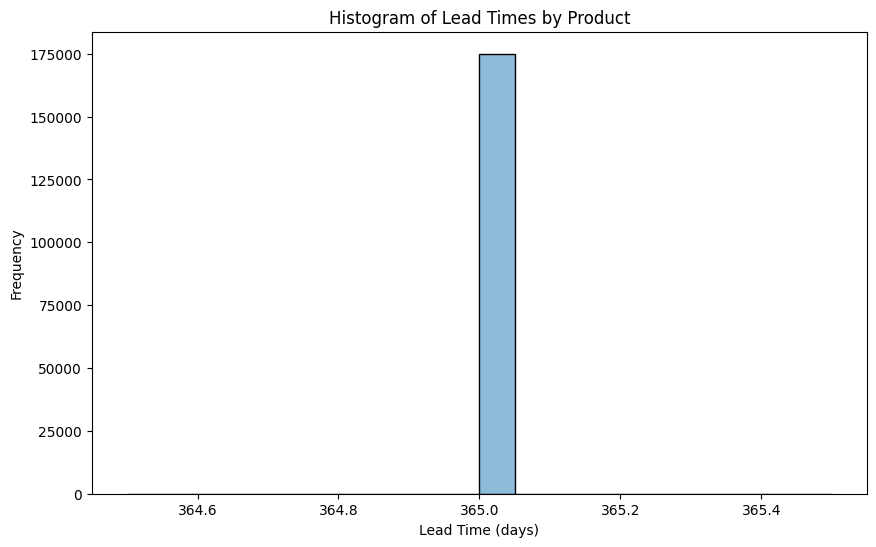

In [31]:
# Plotting histogram of lead times
plt.figure(figsize=(10, 6))
sns.histplot(data=merged_inventory, x='LeadTime', bins=20, kde=True)
plt.title('Histogram of Lead Times by Product')
plt.xlabel('Lead Time (days)')
plt.ylabel('Frequency')
plt.show()

In [32]:
# Calculate maximum daily demand and standard deviation of daily demand for each product
product_demand = merged_inventory.groupby('Description_x')['DailyDemand'].agg(['max', 'std', 'mean'])

print(product_demand.columns)
print(product_demand.shape)
print(product_demand.head())


Index(['max', 'std', 'mean'], dtype='object')
(5933, 3)
                             max       std      mean
Description_x                                       
(RI) 1                  0.041096  0.007865  0.017456
10 Span Pnt Nr CC       0.021918       NaN  0.021918
13 Celsius Svgn Bl      0.032877  0.014315  0.018082
14 Hands Cab Svgn Wash  0.591781  0.127281  0.140046
14 Hands Chard Wash     0.260274  0.046770  0.058204


In [33]:
# Calculate safety stock for each product
product_demand['SafetyStock'] = (product_demand['max'] * merged_inventory['LeadTime'].mean()) + (product_demand['std'] * np.sqrt(merged_inventory['LeadTime'].mean()))

print(product_demand.columns)
print(product_demand.shape)
print(product_demand.head())

Index(['max', 'std', 'mean', 'SafetyStock'], dtype='object')
(5933, 4)
                             max       std      mean  SafetyStock
Description_x                                                    
(RI) 1                  0.041096  0.007865  0.017456    15.150254
10 Span Pnt Nr CC       0.021918       NaN  0.021918          NaN
13 Celsius Svgn Bl      0.032877  0.014315  0.018082    12.273486
14 Hands Cab Svgn Wash  0.591781  0.127281  0.140046   218.431691
14 Hands Chard Wash     0.260274  0.046770  0.058204    95.893533


Calculate Reorder point or threshold of rorder for each product

Reorder Point = Safety Stock + (Average Daily Demand x Lead Time)

In [34]:
# Calculate reorder points for each product
product_demand['ReorderPoint'] = product_demand['mean'] * merged_inventory['LeadTime'].mean() + product_demand['SafetyStock']

print(product_demand.columns)
print(product_demand.shape)
print(product_demand.head())

Index(['max', 'std', 'mean', 'SafetyStock', 'ReorderPoint'], dtype='object')
(5933, 5)
                             max       std      mean  SafetyStock  \
Description_x                                                       
(RI) 1                  0.041096  0.007865  0.017456    15.150254   
10 Span Pnt Nr CC       0.021918       NaN  0.021918          NaN   
13 Celsius Svgn Bl      0.032877  0.014315  0.018082    12.273486   
14 Hands Cab Svgn Wash  0.591781  0.127281  0.140046   218.431691   
14 Hands Chard Wash     0.260274  0.046770  0.058204    95.893533   

                        ReorderPoint  
Description_x                         
(RI) 1                     21.521683  
10 Span Pnt Nr CC                NaN  
13 Celsius Svgn Bl         18.873486  
14 Hands Cab Svgn Wash    269.548574  
14 Hands Chard Wash       117.137977  


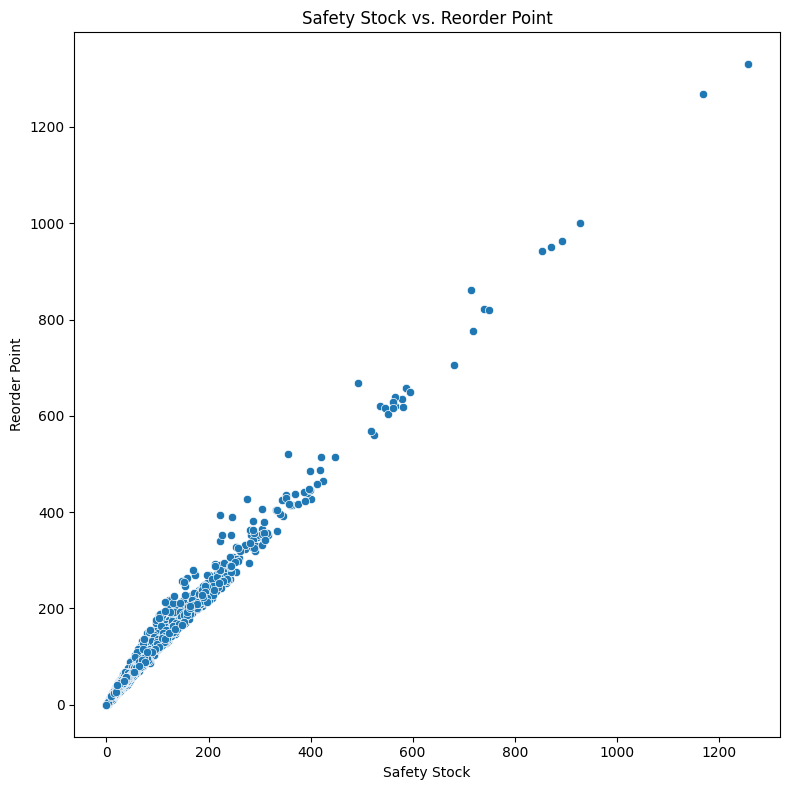

In [35]:
# Plotting scatter plot of safety stock vs. reorder point
plt.figure(figsize=(8, 8))
sns.scatterplot(x='SafetyStock', y='ReorderPoint', data=product_demand)
plt.title('Safety Stock vs. Reorder Point')
plt.xlabel('Safety Stock')
plt.ylabel('Reorder Point')
plt.tight_layout()
plt.show()

# Object 2: 
 Include profit margin calculations and visualizations to identify the most and least profitable products.

In [38]:
# Check the column names in sales_data and purchase_prices
print("Sales Data Columns:", sales_data.columns)
print("Purchase Prices Columns:", purchase_prices.columns)


Sales Data Columns: Index(['InventoryId', 'Store', 'Brand', 'Description', 'Size', 'SalesQuantity',
       'SalesDollars', 'SalesPrice', 'SalesDate', 'Volume', 'Classification',
       'ExciseTax', 'VendorNo', 'VendorName'],
      dtype='object')
Purchase Prices Columns: Index(['Brand', 'Description', 'Price', 'Size', 'Volume', 'Classification',
       'PurchasePrice', 'VendorNumber', 'VendorName'],
      dtype='object')


In [39]:
# Merge sales data with purchase prices using Brand and Description
sales_with_prices = pd.merge(sales_data, purchase_prices, on=['Brand', 'Description'])

# Calculate the profit for each sale
sales_with_prices['Profit'] = (sales_with_prices['SalesPrice'] - sales_with_prices['PurchasePrice']) * sales_with_prices['SalesQuantity']


In [40]:
# Group by product to get total sales and total profit
profit_data = sales_with_prices.groupby('Description')['Profit'].sum().reset_index()
sales_data_grouped = sales_data.groupby('Description')['SalesQuantity'].sum().reset_index()

# Merge profit data with total sales quantity
profit_data = pd.merge(profit_data, sales_data_grouped, on='Description')


In [41]:
# Calculate profit margin
profit_data['ProfitMargin'] = profit_data['Profit'] / (profit_data['SalesQuantity'] * sales_with_prices['SalesPrice'].mean())

print("Profit Data:")
print(profit_data.head())
print(profit_data.shape)

Profit Data:
                  Description  Profit  SalesQuantity  ProfitMargin
0                      (RI) 1  393.80             40      0.637976
1         10 Span Cab Svgn CC   60.72             24      0.163949
2            10 Span Chard CC  198.24             84      0.152933
3           10 Span Pnt Nr CC   73.16             31      0.152933
4  12 Days of Pearls Gift Set   72.80             26      0.181446
(6890, 4)


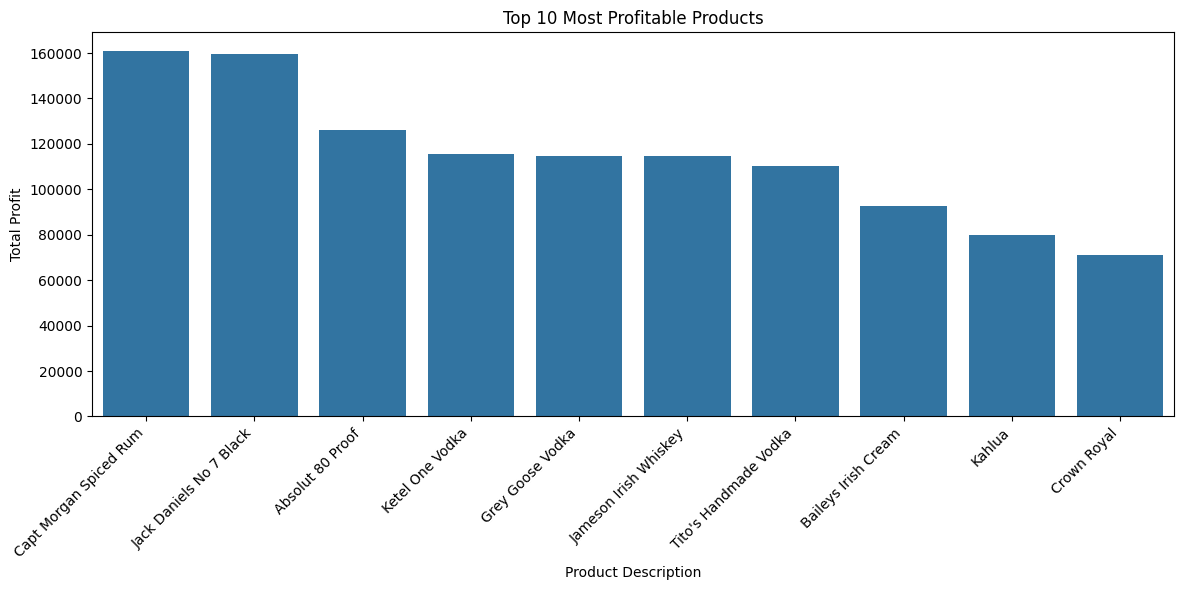

In [42]:
# Visualize the most profitable products
top_profitable_products = profit_data.sort_values(by='Profit', ascending=False).head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x='Description', y='Profit', data=top_profitable_products)
plt.xticks(rotation=45, ha='right')
plt.title('Top 10 Most Profitable Products')
plt.xlabel('Product Description')
plt.ylabel('Total Profit')
plt.tight_layout()
plt.show()


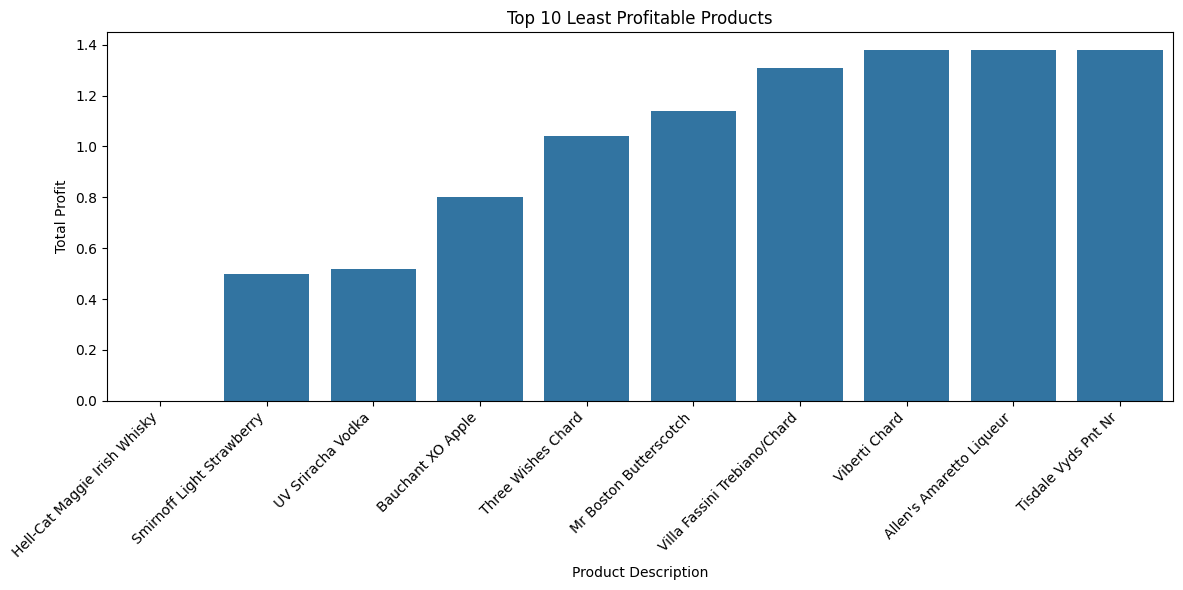

In [43]:
# Visualize the least profitable products
least_profitable_products = profit_data.sort_values(by='Profit', ascending=True).head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x='Description', y='Profit', data=least_profitable_products)
plt.xticks(rotation=45, ha='right')
plt.title('Top 10 Least Profitable Products')
plt.xlabel('Product Description')
plt.ylabel('Total Profit')
plt.tight_layout()
plt.show()

# Object 3: 
Database Integration in MySQL

In [ ]:
# Step 1: Establish the connection
connection = mysql.connector.connect(
    host="localhost",     # Hostname
    user="root",          # Username
    password="root",  # Password
    database="mydatabase",  # Database name
    port=3306             # Port number
)
# Step 2: Create a cursor object
cursor = connection.cursor()

In [ ]:

def create_database_and_tables():
    try:            
        # Delete existing tables 
        cursor.execute("DROP TABLE IF EXISTS SalesFinal, PurchaseFinal, InvoicePurchase, EndInvFinal, BegInvFinal, PurchasePricesDec")
        # Create tables
        cursor.execute("""
        CREATE TABLE IF NOT EXISTS SalesFinal (
            InventoryId VARCHAR(255),
            Store INT,
            Brand INT,
            Description TEXT,
            Size VARCHAR(255),
            SalesQuantity INT,
            SalesDollars FLOAT,
            SalesPrice FLOAT,
            SalesDate DATE,
            Volume INT,
            Classification INT,
            ExciseTax FLOAT,
            VendorNo INT,
            VendorName VARCHAR(255)
        );
        """)
        cursor.execute("""
        CREATE TABLE IF NOT EXISTS PurchaseFinal (
            InventoryId VARCHAR(255),
            Store INT,
            Brand INT,
            Description TEXT,
            Size VARCHAR(255),
            VendorNumber INT,
            VendorName VARCHAR(255),
            PONumber INT,
            PODate DATE,
            ReceivingDate DATE,
            InvoiceDate DATE,
            PayDate DATE,
            PurchasePrice FLOAT,
            Quantity INT,
            Dollars FLOAT,
            Classification INT
        );
        """)
        cursor.execute("""
        CREATE TABLE IF NOT EXISTS InvoicePurchase (
            VendorNumber INT,
            VendorName VARCHAR(255),
            InvoiceDate DATE,
            PONumber INT,
            PODate DATE,
            PayDate DATE,
            Quantity INT,
            Dollars FLOAT,
            Freight FLOAT,
            Approval VARCHAR(255)
        );
        """)
        cursor.execute("""
        CREATE TABLE IF NOT EXISTS EndInvFinal (
            InventoryId VARCHAR(255),
            Store INT,
            City VARCHAR(255),
            Brand INT,
            Description TEXT,
            Size VARCHAR(255),
            onHand INT,
            Price FLOAT,
            endDate DATE
        );
        """)
        cursor.execute("""
        CREATE TABLE IF NOT EXISTS BegInvFinal (
            InventoryId VARCHAR(255),
            Store INT,
            City VARCHAR(255),
            Brand INT,
            Description TEXT,
            Size VARCHAR(255),
            onHand INT,
            Price FLOAT,
            startDate DATE
        );
        """)
        cursor.execute("""
        CREATE TABLE IF NOT EXISTS PurchasePricesDec (
            Brand INT,
            Description TEXT,
            Price FLOAT,
            Size VARCHAR(255),
            Volume INT,
            Classification INT,
            PurchasePrice FLOAT,
            VendorNumber INT,
            VendorName VARCHAR(255)
        );
        """)
        print("Database and tables created successfully.")

    except Error as e:
        print(f"Error: {e}")

# Call the function to create the database and tables
create_database_and_tables()


Database and tables created successfully.


In [ ]:
# Settle issues when loading to db
# Clean the 'Volume' column in purchase_prices 
# Convert 'Volume' to numeric, setting errors='coerce' will convert invalid parsing to NaN
purchase_prices['Volume'] = pd.to_numeric(purchase_prices['Volume'], errors='coerce')

# Fill NaN values (or decide how to handle them)
# For example, you might want to set them to a default value or drop those rows
purchase_prices['Volume'].fillna(0, inplace=True)  # Setting NaN to 0

C:\Users\navsa\AppData\Local\Temp\ipykernel_3092\3802311587.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  purchase_prices['Volume'].fillna(0, inplace=True)  # Setting NaN to 0


In [ ]:
# Insert data into database
def insert_dataframe_to_db(df, table_name):
    cols = ', '.join(df.columns)
    placeholders = ', '.join(['%s'] * len(df.columns))
    sql = f"INSERT INTO {table_name} ({cols}) VALUES ({placeholders})"
    
    try:
        for row in df.itertuples(index=False):
            cursor.execute(sql, row)
        connection.commit()
        print(f"Data inserted into {table_name} successfully.")
    except Error as e:
        print(f"Error inserting into {table_name}: {e}")
        connection.rollback()

# Call the function for each DataFrame
# insert_dataframe_to_db(sales_data, 'SalesFinal')
# insert_dataframe_to_db(purchase_data, 'PurchaseFinal')
# insert_dataframe_to_db(invoice_data, 'InvoicePurchase')
# insert_dataframe_to_db(ending_inventory, 'EndInvFinal')
# insert_dataframe_to_db(beginning_inventory, 'BegInvFinal')
insert_dataframe_to_db(purchase_prices, 'PurchasePricesDec')
purchase_prices.fillna(0, inplace=True)  # or any other value suitable for your context


Data inserted into PurchasePricesDec successfully.


In [ ]:
# Fetch data from all tables
def fetch_data_from_db(table_name):
    cursor.execute(f"SELECT * FROM {table_name} LIMIT 5")  # Fetch the first 5 rows
    records = cursor.fetchall()
    for record in records:
        print(record)

# Call the function for each table to verify data insertion
fetch_data_from_db('SalesFinal')
fetch_data_from_db('PurchaseFinal')
fetch_data_from_db('InvoicePurchase')
fetch_data_from_db('EndInvFinal')
fetch_data_from_db('BegInvFinal')
fetch_data_from_db('PurchasePricesDec')

('1_HARDERSFIELD_1004', 1, 1004, 'Jim Beam w/2 Rocks Glasses', '750mL', 1, 16.49, 16.49, datetime.date(2016, 1, 1), 750, 1, 0.79, 12546, 'JIM BEAM BRANDS COMPANY    ')
('1_HARDERSFIELD_1004', 1, 1004, 'Jim Beam w/2 Rocks Glasses', '750mL', 2, 32.98, 16.49, datetime.date(2016, 1, 2), 750, 1, 1.57, 12546, 'JIM BEAM BRANDS COMPANY    ')
('1_HARDERSFIELD_1004', 1, 1004, 'Jim Beam w/2 Rocks Glasses', '750mL', 1, 16.49, 16.49, datetime.date(2016, 1, 3), 750, 1, 0.79, 12546, 'JIM BEAM BRANDS COMPANY    ')
('1_HARDERSFIELD_1004', 1, 1004, 'Jim Beam w/2 Rocks Glasses', '750mL', 1, 14.49, 14.49, datetime.date(2016, 1, 8), 750, 1, 0.79, 12546, 'JIM BEAM BRANDS COMPANY    ')
('1_HARDERSFIELD_1005', 1, 1005, "Maker's Mark Combo Pack", '375mL 2 Pk', 2, 69.98, 34.99, datetime.date(2016, 1, 9), 375, 1, 0.79, 12546, 'JIM BEAM BRANDS COMPANY    ')
('69_MOUNTMEND_8412', 69, 8412, 'Tequila Ocho Plata Fresno', '750mL', 105, 'ALTAMAR BRANDS LLC         ', 8124, datetime.date(2015, 12, 21), datetime.date(201

In [ ]:
# Close the cursor and connection
cursor.close()
connection.close()


# Objective 4
Demand Forecasting: Implement machine learning models to predict future demand based on historical sales data.

In [44]:
# Aggregate sales quantity by date
daily_sales = sales_data.groupby('SalesDate')['SalesQuantity'].sum().reset_index()

print(daily_sales.head())

   SalesDate  SalesQuantity
0 2016-01-01          49911
1 2016-01-02          93114
2 2016-01-03          53037
3 2016-01-04          41341
4 2016-01-05          40831


In [45]:
# Split the data into training and testing sets
train_size = int(len(daily_sales) * 0.8)
train_data = daily_sales[:train_size]
test_data = daily_sales[train_size:]

print(train_data.shape, test_data.shape)


(48, 2) (12, 2)


In [46]:
def create_features(df):
    df['day_of_week'] = df['SalesDate'].dt.dayofweek
    df['month'] = df['SalesDate'].dt.month
    df['day_of_year'] = df['SalesDate'].dt.dayofyear
    df['week_of_year'] = df['SalesDate'].dt.isocalendar().week
    return df

train_data = create_features(train_data)
test_data = create_features(test_data)

print(train_data.head())


   SalesDate  SalesQuantity  day_of_week  month  day_of_year  week_of_year
0 2016-01-01          49911            4      1            1            53
1 2016-01-02          93114            5      1            2            53
2 2016-01-03          53037            6      1            3            53
3 2016-01-04          41341            0      1            4             1
4 2016-01-05          40831            1      1            5             1


C:\Users\navsa\AppData\Local\Temp\ipykernel_20200\1394762771.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['day_of_week'] = df['SalesDate'].dt.dayofweek
C:\Users\navsa\AppData\Local\Temp\ipykernel_20200\1394762771.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['month'] = df['SalesDate'].dt.month
C:\Users\navsa\AppData\Local\Temp\ipykernel_20200\1394762771.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

In [49]:
# Define the features and target
X_train = train_data[['day_of_week', 'month', 'day_of_year', 'week_of_year']]
y_train = train_data['SalesQuantity']
X_test = test_data[['day_of_week', 'month', 'day_of_year', 'week_of_year']]
y_test = test_data['SalesQuantity']

# Train a linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
train_preds = model.predict(X_train)
test_preds = model.predict(X_test)

# Evaluate the model
train_mae = mean_absolute_error(y_train, train_preds)
test_mae = mean_absolute_error(y_test, test_preds)
train_rmse = mean_squared_error(y_train, train_preds, squared=False)
test_rmse = mean_squared_error(y_test, test_preds, squared=False)

print(f"Train MAE: {train_mae}, Test MAE: {test_mae}")
print(f"Train RMSE: {train_rmse}, Test RMSE: {test_rmse}")


Train MAE: 15193.080129555436, Test MAE: 15080.218840542453
Train RMSE: 21429.484729619708, Test RMSE: 18029.403673842888


c:\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


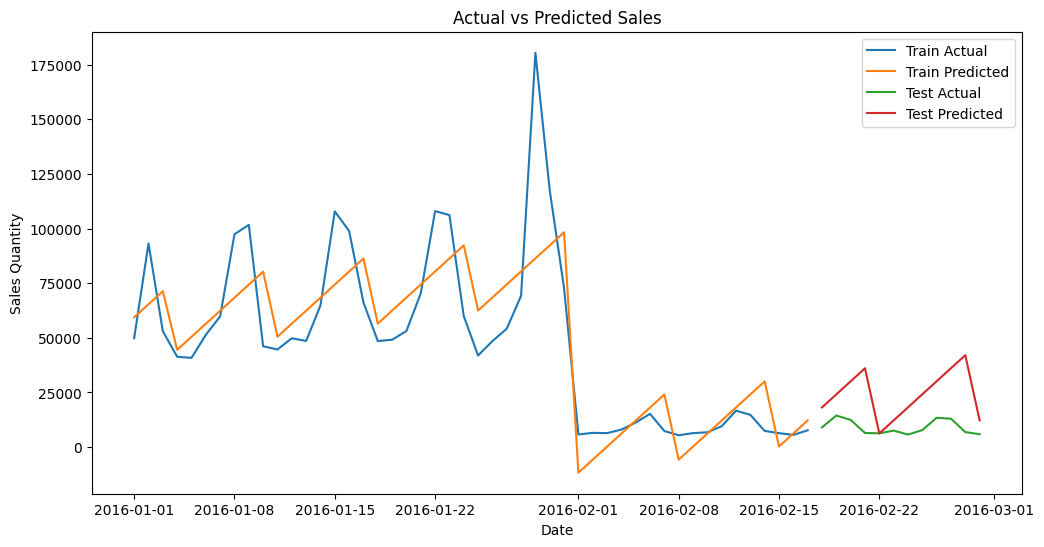

In [50]:
# Plot the actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(train_data['SalesDate'], y_train, label='Train Actual')
plt.plot(train_data['SalesDate'], train_preds, label='Train Predicted')
plt.plot(test_data['SalesDate'], y_test, label='Test Actual')
plt.plot(test_data['SalesDate'], test_preds, label='Test Predicted')
plt.title('Actual vs Predicted Sales')
plt.xlabel('Date')
plt.ylabel('Sales Quantity')
plt.legend()
plt.show()


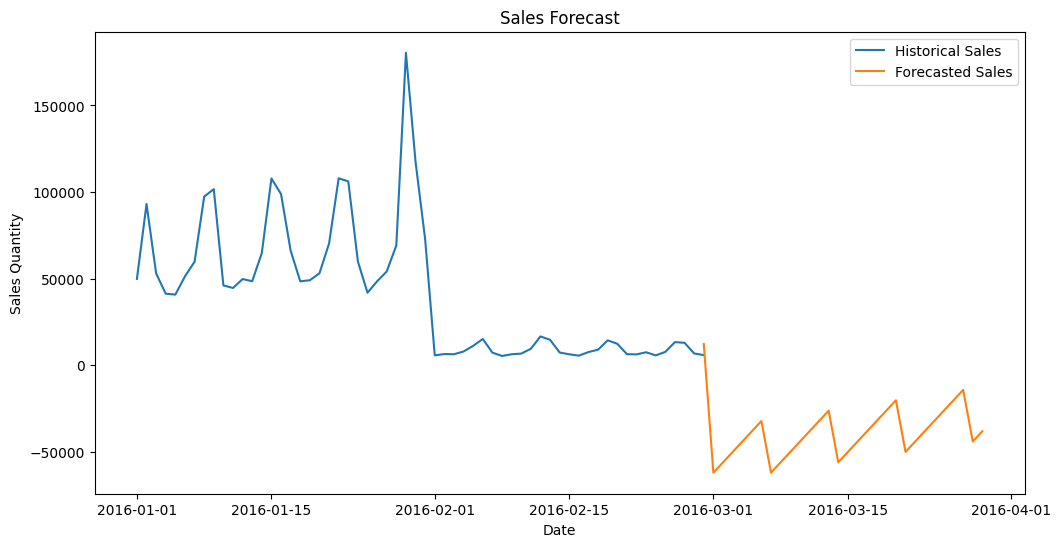

In [51]:
# Create future dates
future_dates = pd.date_range(start=daily_sales['SalesDate'].max(), periods=30, freq='D')
future_df = pd.DataFrame({'SalesDate': future_dates})
future_df = create_features(future_df)

# Predict future sales
future_preds = model.predict(future_df[['day_of_week', 'month', 'day_of_year', 'week_of_year']])

# Plot the forecasted sales
plt.figure(figsize=(12, 6))
plt.plot(daily_sales['SalesDate'], daily_sales['SalesQuantity'], label='Historical Sales')
plt.plot(future_dates, future_preds, label='Forecasted Sales')
plt.title('Sales Forecast')
plt.xlabel('Date')
plt.ylabel('Sales Quantity')
plt.legend()
plt.show()


# Objective 5
The auto reorder notifier monitors inventory levels against predefined thresholds and sends email alerts when stock falls below these limits.

In [64]:
# Email settings
email_from_username = "anandnavsanya"
email_to = "navsanyanand@gmail.com"
email_subject = "Reorder Notification"
email_password = "opfd qrpr vrgl vybu"  # Store password securely in a separate file or environment variable


In [65]:
# Function to send email notifications for reorders
def send_reorder_notification(items_to_reorder):
    # Create a DataFrame from items to reorder
    reorder_df = pd.DataFrame(items_to_reorder)
    
    # Define the filename
    filename = "reorder_list.csv"
    
    # Save the DataFrame to a CSV file
    reorder_df.to_csv(filename, index=False)
    
    # Prepare the email
    yag = yagmail.SMTP(email_from_username, email_password)
    email_subject = "Reorder Notification"
    email_body = "Please find attached the list of products that need to be reordered."
    
    # Send the email with attachment
    yag.send(to=email_to, subject=email_subject, contents=email_body, attachments=filename)
    
    print("Reorder email sent with attachment.")
    
    # Optional: remove the file after sending the email
    os.remove(filename)


In [68]:
# Check if there are items to reorder
if not items_to_reorder.empty:
    send_reorder_notification(items_to_reorder["Description_begin"])
else:
    print("No items need to be reordered.")

Reorder email sent with attachment.
